# Code for generating Figure 4

## "Crick-like error correction efficiently extends memory lifetime by introducing a slow time scale"

This Python notebook contains code for generating the fourth figure from the paper "Storing long-lived memories via molecular error correction: a minimal mathematical model of Crick's memory switch".

In [203]:
%load_ext autoreload
%autoreload 2

# imports
import numpy as np
import matplotlib.pyplot as plt

import pickle

from functions.solutions import get_probs_crick, get_probs_ncrick
from functions.solutions import get_eigenvectors_crick, get_eigenvalues_crick, get_probs_ncrick_shortcut, triples_sum_to

from functions.firstpassage import get_FPavg_crick
from functions.MI import get_MI, get_capacity, get_t_life, get_performances, get_t_life_2D, get_MI_2D, get_performances_2D

from functions.gillespie import simulate_ssa

from functions.plotting import plot_colorbar, plot_eigenvector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
# aesthetics
lw = 4
c_red = (1,0,0)
c_green = np.array([57,181,74])/255

c_eps_low = 'palevioletred'
c_eps_med = 'hotpink'
c_eps_hi = 'pink'

c_k_low = 'saddlebrown'
c_k_med = 'darkorange'
c_k_hi = (255/255, 184/255, 74/255)

sim_colors = ['chocolate', 'fuchsia', 'deepskyblue', 'gold'] 

c_N_low = 'indigo'
c_N_med = 'darkviolet'
c_N_hi = 'mediumorchid'

c_b_hi = 'tomato'
c_b_med = 'crimson'
c_b_low = 'maroon'

In [108]:
# saving-related utility function
results_folder = 'results/fig4/'
format_list = ['.png', '.svg', '.pdf']

def save_file(name):
    for end in format_list:
        plt.savefig(results_folder+name+end, bbox_inches='tight', transparent=True)
    return

<center>
<img src="fig_images/fig4-crick.png" width="1000"/></center>

**Caption.** (a) Schematic of Crick switch and three example stochastic simulations ($\gamma = 1, \epsilon = 0.01, k = 10$). (b) When $k \gg \gamma$, if turnover moves the system into its partially marked state, it tends to quickly transition back into the fully marked state. In this sense, the system performs `error correction'. (c) Eigenvalue gap vs $k$ ($\gamma = 1, \epsilon = 0.1$). (d) Time scales $\tau_i = - 1/\lambda_i$ vs $k$ ($\gamma = 1, \epsilon = 0.1$). (e) First and second right eigenvectors of the Crick switch's Hamiltonian for different values of $k$. Blue: probability inflow, red: probability outflow. Note that as $k$ increases, the first eigenvector ($\vec{v}_{\text{slow}}$) increasingly corresponds to probability moving out of the fully marked state and into the unmarked state; the second eigenvector ($\vec{v}_{\text{fast}}$) increasingly corresponds to probability moving out of the partially marked state and into the fully marked state. (f) Mean first-passage time vs $k$ ($\gamma = 1, \epsilon = 0.01$). (g) State occupancy probabilities over time for the Crick switch ($\gamma = 1, \epsilon = 0.01, k = 10$). Shaded region: time before $\tau_{\text{slow}} = - 1/\lambda_1$. (h) Mutual information vs time for different values of $k$ ($\gamma = 1, \epsilon = 0.01$). (i) Lifetime vs $k$ for different values of the ambient marking rate $\epsilon$ ($\gamma = 1$). (j) Same as (i), but capacity. (k) Same as (i), but performance. (l) Mutual information vs time for different values of $N$ ($\gamma = 1, \epsilon = 0.01, k = 100$). (m) Lifetime vs $\log_{10} k$ (left to right) and $\log_{10} N$ (bottom to top) ($\gamma = 1, \epsilon = 0.01$). (n) Same as (m), but capacity. (o) Same as (m), but performance.

## a. Gillespie simulations, Crick switch

Simulate the Crick switch using the Gillespie algorithm.

In [245]:
# propensity function for Crick switch
def prop_crick(state, params):
    eps, gamma, k = params['eps'], params['gamma'], params['k']
    # state: (num_samples, D)
    return np.array( [ 2*eps*state[:,0], gamma*state[:,1], (eps + k)*state[:,1], 2*gamma*state[:,2]  ]).T


# Set up propensity function and stoichiometry vector
params = {'eps':0.01, 'gamma':1, 'k':10}
prop = lambda state: prop_crick(state, params)
stoich = np.array([ [ -1, 1, 0 ],
                    [  1,-1, 0 ],
                    [  0,-1, 1 ],
                    [  0, 1,-1 ]])

In [247]:
num_species = 3; num_samples = 3
num_steps = 60

x0 = np.zeros((num_samples, num_species))
x0[:,2] = 1

# Simulate
np.random.seed(1)  
t_rec, counts = simulate_ssa(x0, prop, stoich, num_steps)

# Convert one-hot encoding to (0, 1, 2) encoding
arg = np.flip(np.argsort(t_rec[1,:]))
test = counts[:,:,1] + counts[:,:,2]*2

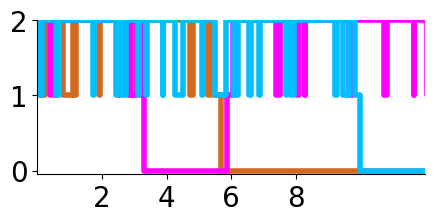

In [249]:
fig, ax = plt.subplots(figsize=(5,2))

plt.plot(t_rec[:,0], test[:,0], drawstyle='steps-post',color=sim_colors[0],linewidth=lw)
plt.plot(t_rec[:,1], test[:,1], drawstyle='steps-post',color=sim_colors[1],linewidth=lw)
plt.plot(t_rec[:,2], test[:,2], drawstyle='steps-post',color=sim_colors[2],linewidth=lw)
plt.ylim(-0.05, 2)
plt.xlim(0, 12)

ax.spines[['right', 'top']].set_visible(False)
plt.xticks([2, 4, 6, 8],fontsize=20); plt.yticks([0, 1, 2],  fontsize=20)
save_file('gillespie_crick')
plt.show()

## c. Eigenvalue gap vs catalysis rate $k$

Eigenvalue gap $\Delta$ vs catalysis rate $k$. $\Delta$ is defined as:

$\begin{equation}
\Delta = \frac{\sqrt{(\epsilon + \gamma + k)^2 + 4 k (\gamma - \epsilon)} - (\epsilon + \gamma + k)}{2}
\end{equation}$

The eigenvalues of the Crick switch sensitively depend on it, since $\lambda_1 = - (\epsilon + \gamma - \Delta)$ and $\lambda_2 = - [ 2 (\epsilon + \gamma) + \Delta + k]$.

In [765]:
eps, gamma = 0.1, 1
k_min, k_max, num_k = 0, 25, 200
k = np.linspace(k_min, k_max, num_k)
Delta = 0.5*(  np.sqrt( (eps + gamma + k)**2 + 4*k*(gamma - eps)   ) - (eps + gamma + k)  )

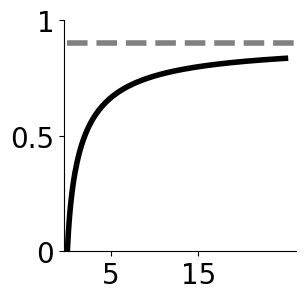

In [771]:
fig, ax = plt.subplots(figsize=(3,3))

plt.plot(k, Delta, linewidth=lw, color='black')

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(-0.4,None); plt.ylim(0, None)
plt.xticks([5, 15], fontsize=20)
plt.yticks([0, 0.5, 1], ['0','0.5','1'], fontsize=20)
plt.plot(t, (gamma-eps)*np.ones_like(t), color='gray', linestyle='--', linewidth=4)

save_file('gap_crick')
plt.show()

## d. Model time scales vs catalysis rate $k$

Time scales associated with Crick switch dynamics vs the catalysis rate $k$. The two time scales are $\tau_{slow} = - 1/\lambda_1$ (black) and $\tau_{fast} = - 1/\lambda_2$ (orange). Notice how, as $k$ increases, the slow time scale gets significantly longer.

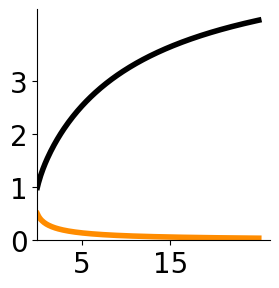

In [773]:
lamb_max = 2*(eps + gamma) + Delta + k
lamb_min = eps + gamma - Delta


fig, ax = plt.subplots(figsize=(3,3))

ax.spines[['right', 'top']].set_visible(False)
plt.plot(k, (eps + gamma)/lamb_min, linewidth=lw, color='black')
plt.plot(k, (eps + gamma)/lamb_max, linewidth=lw, color='darkorange')

plt.xlim(0,None)
plt.ylim(0, None)
plt.xticks([5, 15],fontsize=20); 
plt.yticks([0, 1, 2, 3],fontsize=20); 
ax.spines[['right', 'top']].set_visible(False)

save_file('eigenvalues_crick')
plt.show()

## e. Visualize eigenvectors of Crick switch for different values of $k$

Visualize eigenvectors of the Crick switch ($\boldsymbol{v}_{slow}$ and $\boldsymbol{v}_{fast}$) for different values of $k$ ($k = 0, 1, 10$). In our visualization, blue means probability inflow and red means probability outflow.

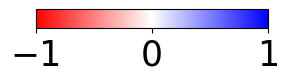

In [258]:
# Plot colorbar
name = 'colorbar'
plot_colorbar(name, save_file)

k = 0


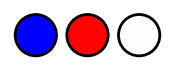

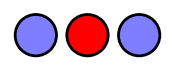

k = 1


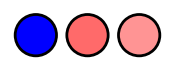

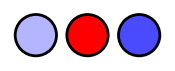

k = 10


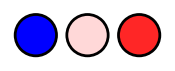

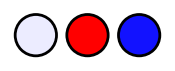

In [260]:
eps, gamma, k = 0.01, 1, 0; params = {'eps':eps, 'gamma':gamma, 'k':k}
eigenvectors = get_eigenvectors_crick(params)
v1 = eigenvectors['v1']; v2 = eigenvectors['v2']

print('k = 0')
plot_eigenvector('eigenvector_crick_v1_zero', v1, save_file)
plot_eigenvector('eigenvector_crick_v2_zero', v2, save_file)

# ----------

eps, gamma, k = 0.01, 1, 1; params = {'eps':eps, 'gamma':gamma, 'k':k}
eigenvectors = get_eigenvectors_crick(params)
v1 = eigenvectors['v1']; v2 = eigenvectors['v2']

print('k = 1')
plot_eigenvector('eigenvector_crick_v1_med', v1, save_file)
plot_eigenvector('eigenvector_crick_v2_med', v2, save_file)

# -------------

eps, gamma, k = 0.01, 1, 10; params = {'eps':eps, 'gamma':gamma, 'k':k}
eigenvectors = get_eigenvectors_crick(params)
v1 = eigenvectors['v1']; v2 = eigenvectors['v2']

print('k = 10')
plot_eigenvector('eigenvector_crick_v1_hi', v1, save_file)
plot_eigenvector('eigenvector_crick_v2_hi', v2, save_file)

## f. Mean first-passage time vs catalysis rate $k$

Plot mean first-passage time to unmarked state vs catalysis rate $k$ for Crick switch. Notice that it is linear in $k$.

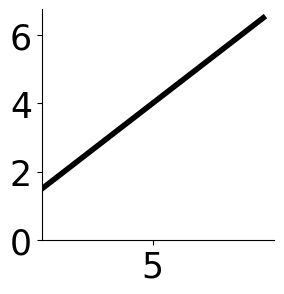

In [267]:
eps, gamma = 0.01, 1; params = {'eps':eps, 'gamma':gamma}
k_min, k_max, num_k = 0, 10, 200
k = np.linspace(k_min, k_max, num_k)

t_avg = get_FPavg_crick(k, params)

# -----

fig, ax = plt.subplots(figsize=(3,3))

ax.spines[['right', 'top']].set_visible(False)
plt.plot(k, t_avg, linewidth=lw, color='black')

plt.xlim(0,None)
plt.ylim(0, None)
plt.xticks([5],fontsize=25); 
plt.yticks([0, 2, 4, 6],fontsize=25); 
ax.spines[['right', 'top']].set_visible(False)

save_file('FPavg_crick')
plt.show()

## g. State occupancy probabilities, Crick switch

Plot state occupancy probabilities $p_0(t)$ (unmarked probability), $p_1(t)$ (partially marked probability), and $p_2(t)$ (fully marked probability) over time for the Crick switch.

In [ ]:
t_min, t_max, num_t = 0, 25, 200
t = np.linspace(t_min, t_max, num_t)

eps, gamma, k = 0.01, 1, 10; params = {'eps':eps, 'gamma':gamma, 'k':k}
_, p_t = get_probs_crick(t, params)
p_minus, p_mid, p_plus = p_t.T

tau = 1/(eps + gamma)

eigenvalues = get_eigenvalues_crick(params)
tau_slow = eigenvalues['tau_1']

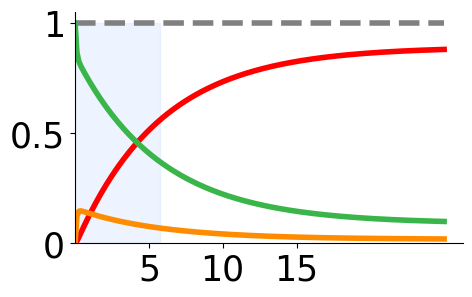

In [182]:
fig, ax = plt.subplots(figsize=(5,3))

plt.fill_between(np.array([0,tau_slow]), np.array([1,1]), alpha=0.25, color=np.array([187,214,255])/255) 
plt.plot(t, np.ones_like(t), color='gray', linestyle='--', linewidth=lw)

plt.plot(t, p_minus, linewidth=lw, color=c_red)
plt.plot(t, p_mid, linewidth=lw, color='darkorange')
plt.plot(t, p_plus, linewidth=lw, color=c_green)

ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0,None); plt.ylim(0, 1.05)
plt.xticks([5, 10, 15],fontsize=25)
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=25)

name = 'state_occ_crick'
save_file(name)
plt.show()

## h. Mutual information vs time, different values of $k$

Mutual information vs time for the Crick switch for different values of $k$ ($k = 0, 1, 10, 100$). As $k$ increases, the height of the curve goes down (i.e., capacity decreases) and it extends more to the right (i.e., lifetime increases).

In [ ]:
t_min, t_max, num_t = 0.0, 8, 5000
t = np.linspace(t_min, t_max, num_t)

def get_MI_crick(t, eps, gamma, k):
    params = {'eps':eps, 'gamma':gamma, 'k':k}
    p_z_given_0, p_z_given_1 = get_probs_crick(t, params)
    MI = get_MI(p_z_given_0, p_z_given_1)
    return MI

MI_base = get_MI_crick(t, eps=0.01, gamma=1, k=0)
MI_low = get_MI_crick(t, eps=0.01, gamma=1, k=1)
MI_med = get_MI_crick(t, eps=0.01, gamma=1, k=10)
MI_hi = get_MI_crick(t, eps=0.01, gamma=1, k=100)

t_life_base = t[np.argwhere(MI_base <= 0.5*MI_base[0])[0]]
t_life_low = t[np.argwhere(MI_low <= 0.5*MI_low[0])[0]]
t_life_med = t[np.argwhere(MI_med <= 0.5*MI_med[0])[0]]
t_life_hi = t[np.argwhere(MI_hi <= 0.5*MI_hi[0])[0]]

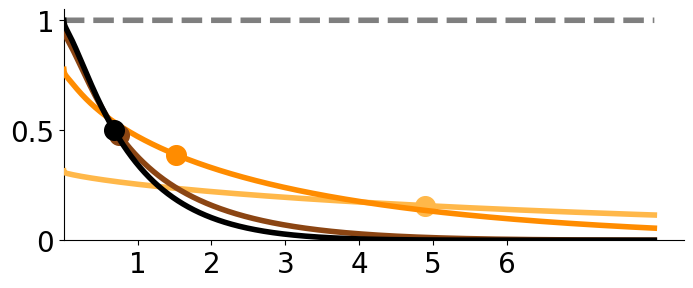

In [501]:
fig, ax = plt.subplots(figsize=(8,3))


plt.plot(t, MI_hi, color=c_k_hi, linewidth=lw, zorder=3)
plt.scatter(t_life_hi, 0.5*MI_hi[0], color=c_k_hi, s=200, zorder=3)

plt.plot(t, MI_med, color=c_k_med, linewidth=lw, zorder=3)
plt.scatter(t_life_med, 0.5*MI_med[0], color=c_k_med, s=200, zorder=3)

plt.plot(t, MI_low, color=c_k_low, linewidth=lw, zorder=3)
plt.scatter(t_life_low, 0.5*MI_low[0], color=c_k_low, s=200, zorder=3)

plt.plot(t, MI_base, linewidth=lw, zorder=3, color='black')
plt.scatter(t_life_base, 0.5*MI_base[0], color='black', s=200, zorder=3)

plt.plot(t, np.ones_like(t), linestyle='--', color='black', linewidth=4, alpha=0.5) 


ax.spines[['right', 'top']].set_visible(False)
plt.xticks([0, 1, 2, 3],fontsize=20); 
plt.xticks([1, 2, 3, 4, 5, 6],fontsize=20); 
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=20)
plt.xlim(0., None); plt.ylim(0, None)

save_file('MI_crick_k')
plt.show()

## i. Lifetime vs catalysis rate $k$ for Crick switch, different levels of marking noise

Plot lifetime vs catalysis rate $k$ for the Crick switch, for different levels of marking noise ($\epsilon = 0.001, 0.01, 0.1$). Increasing $k$ generally increases memory lifetime, even across a wide range of marking noise levels.

In [238]:
t_min, t_max, num_t = 0, 100, 10000
t = np.linspace(t_min, t_max, num_t)

k_list = np.linspace(0, 100, 100); num_k = len(k_list)


params_list = []
for i in range(num_k): params_list.append( {'eps':0.001, 'gamma':1., 'k':k_list[i]}   )
t_life_low = get_t_life(t, params_list, get_probs_crick, get_MI)

params_list = []
for i in range(num_k): params_list.append( {'eps':0.01, 'gamma':1., 'k':k_list[i]}   )
t_life_med = get_t_life(t, params_list, get_probs_crick, get_MI)

params_list = []
for i in range(num_k): params_list.append( {'eps':0.1, 'gamma':1., 'k':k_list[i]}   )
t_life_hi = get_t_life(t, params_list, get_probs_crick, get_MI)

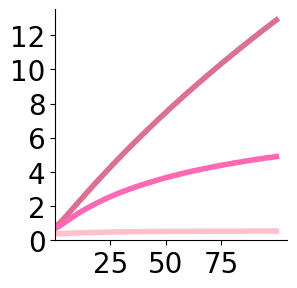

In [240]:
fig, ax = plt.subplots(figsize=(3,3))

plt.plot(k_list, t_life_low, linewidth=lw, color=c_eps_low)
plt.plot(k_list, t_life_med, linewidth=lw, color=c_eps_med)
plt.plot(k_list, t_life_hi, linewidth=lw, color=c_eps_hi)

ax.spines[['right', 'top']].set_visible(False)
plt.xticks([25, 50, 75],fontsize=20); 
plt.yticks(fontsize=20);   
plt.ylim(0, None); plt.xlim(0, None)

save_file('lifetime_crick')
plt.show()

## j. Capacity vs catalysis rate $k$ for Crick switch, different levels of marking noise

Plot capacity vs catalysis rate $k$ for the Crick switch, for different levels of marking noise ($\epsilon = 0.001, 0.01, 0.1$). Increasing $k$ always increases the false-positive probability, and hence always decreases capacity.

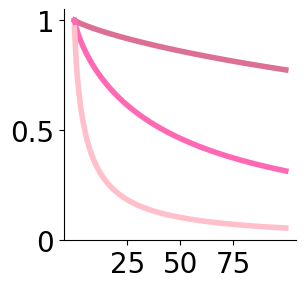

In [523]:
small = 1e-15

k_list = np.linspace(0, 100, 100); num_k = len(k_list)

def get_capacity_crick(eps, gamma, k):
    p_crick = eps*(eps + k)/( (eps + gamma)**2 + k*eps  ) + small
    C = get_capacity(p_crick)
    return C

C_low = get_capacity_crick(0.001, 1, k_list)
C_med = get_capacity_crick(0.01, 1, k_list)
C_hi = get_capacity_crick(0.1, 1, k_list)


fig, ax = plt.subplots(figsize=(3,3))

plt.plot(k_list, C_low, color=c_eps_low, linewidth=lw)
plt.plot(k_list, C_med, color=c_eps_med, linewidth=lw)
plt.plot(k_list, C_hi, color=c_eps_hi, linewidth=lw)
plt.ylim(0, 1.05)
plt.xticks([25, 50, 75], fontsize=20); 
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'],fontsize=20); 
ax.spines[['right', 'top']].set_visible(False)
save_file('capacity_crick')
plt.show()

## k. Performance vs catalysis rate $k$ for Crick switch, different levels of marking noise

Plot performance vs catalysis rate $k$ for the Crick switch, for different levels of marking noise ($\epsilon = 0.001, 0.01, 0.1$). It is hard to notice, but for the largest level of marking noise, the performance curve monotonically decreases, which means that error correction is *not* helpful.

In [527]:
t_min, t_max, num_t = 0, 200, 10000
t = np.linspace(t_min, t_max, num_t)

k_list = np.linspace(0, 200, 100); num_k = len(k_list)


tau = 100

params_list = []
for i in range(num_k): params_list.append( {'eps':0.001, 'gamma':1., 'k':k_list[i]}   )
J_low = get_performances(t, params_list, get_probs_crick, get_MI, tau=tau )

params_list = []
for i in range(num_k): params_list.append( {'eps':0.01, 'gamma':1., 'k':k_list[i]}   )
J_med = get_performances(t, params_list, get_probs_crick, get_MI, tau=tau )

params_list = []
for i in range(num_k): params_list.append( {'eps':0.1, 'gamma':1., 'k':k_list[i]}   )
J_hi = get_performances(t, params_list, get_probs_crick, get_MI, tau=tau )

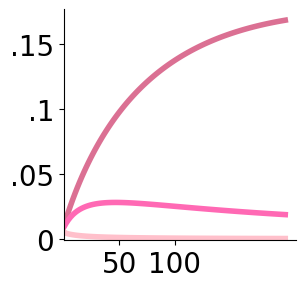

In [551]:
fig, ax = plt.subplots(figsize=(3,3))
plt.plot(k_list, J_low, color=c_eps_low, linewidth=lw)
plt.plot(k_list, J_med, color=c_eps_med, linewidth=lw)
plt.plot(k_list, J_hi, color=c_eps_hi, linewidth=lw)


ax.spines[['right', 'top']].set_visible(False)
plt.xlim(0,None); plt.ylim(-0.001, None)
plt.xticks([50, 100],fontsize=20)
plt.yticks([0, 0.05, 0.1, 0.15],['0','.05','.1','.15'],fontsize=20)

save_file('performance_crick')
plt.show()

## l. Mutual information vs time for $N$ Crick switches, different values of $N$

Mutual information vs time for $N$ Crick switches, different values of $N$ ($N = 1, 2, 10, 100, 1000$). If $N > N'$, the mutual information curve for $N$ is higher than that for $N'$ at all times $t > 0$.

In [621]:
t_min, t_max, num_t = 1e-5, 100, 200
t = np.linspace(t_min, t_max, num_t)

eps, gamma, k = 0.01, 1, 100; params = {'eps':eps, 'gamma':gamma, 'k':k}


p_og_0, p_og_1 = get_probs_crick(t, params)
MI_og = get_MI(p_og_0, p_og_1)
t_life_og = t[np.argwhere(MI_og <= 0.5*MI_og[0])[0]]


N_list = [2, 10, 100, 1000]
num_N = len(N_list)


MI_list = []; t_life_list = []
for N in range(0, num_N):
    params['N'] = N_list[N]
    p_z_given_0, p_z_given_1 = get_probs_ncrick(t, params)
    #print(np.isnan(np.sum(p_z_given_1)))
    
    MI = get_MI(p_z_given_0, p_z_given_1)
    t_life = t[np.argwhere(MI <= 0.5*MI[0])[0]]

    MI_list.append(MI); t_life_list.append(t_life)

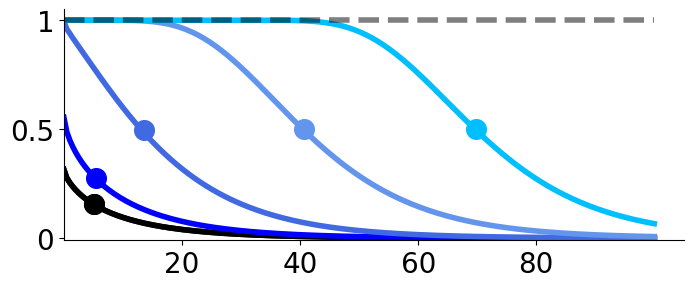

In [623]:
colors = ['blue', 'royalblue', 'cornflowerblue', 'deepskyblue', 'cyan']


fig, ax = plt.subplots(figsize=(8,3))

plt.plot(t, MI_og, color='black', linewidth=lw)
plt.scatter(t_life_og, 0.5*MI_og[0], color='black', s=200, zorder=3)

plt.plot(t, MI_og, color='black', linewidth=lw)
plt.scatter(t_life_og, 0.5*MI_og[0], color='black', s=200, zorder=3)

for N in range(0, num_N):
    MI = MI_list[N]; t_life = t_life_list[N]
    plt.plot(t, MI, linewidth=lw, color=colors[N])
    plt.scatter(t_life, 0.5*MI[0], color=colors[N], s=200, zorder=3)


plt.plot(t, np.ones_like(t), linestyle='--', color='black', linewidth=4, alpha=0.5) 


ax.spines[['right', 'top']].set_visible(False)
plt.xticks([20, 40, 60, 80],fontsize=20); 
plt.yticks([0,0.5, 1], ['0','0.5', '1'], fontsize=20)
plt.xlim(0, None); plt.ylim(-0.01, None)

save_file('MI_crick_vs_N')
plt.show()

## m. Lifetime vs $k$ and $N$ for Crick switch

Plot lifetime vs $k$ and $N$ for Crick switch. We considered three orders of magnitude for $k$ and $N$: $k$ between $1$ and $1000$, and $N$ between $1$ and $1000$. The below computations actually also do most of the computations necessary for panel (o).

In [279]:
t_min, t_max, num_t = 1e-5, 100, 500
t = np.linspace(t_min, t_max, num_t)

eps = 0.01
gamma = 1
k = np.logspace(0, 3, 10); num_k = len(k)
N = np.unique(np.logspace(0, 3, 10, dtype=int)); num_N = len(N)
print(N)

params_list = []
states_list = []
for j in range(num_N):
    states_list.append(triples_sum_to(N[j]))

MI_grid = get_MI_2D(t, k, N, eps, gamma, states_list, get_probs_ncrick_shortcut, get_MI)  # takes a few min

[   1    2    4   10   21   46  100  215  464 1000]
k: 1.0, N: 1
k: 1.0, N: 2
k: 1.0, N: 4
k: 1.0, N: 10
k: 1.0, N: 21
k: 1.0, N: 46
k: 1.0, N: 100
k: 1.0, N: 215
k: 1.0, N: 464
k: 1.0, N: 1000
k: 2.154434690031884, N: 1
k: 2.154434690031884, N: 2
k: 2.154434690031884, N: 4
k: 2.154434690031884, N: 10
k: 2.154434690031884, N: 21
k: 2.154434690031884, N: 46
k: 2.154434690031884, N: 100
k: 2.154434690031884, N: 215
k: 2.154434690031884, N: 464
k: 2.154434690031884, N: 1000
k: 4.641588833612778, N: 1
k: 4.641588833612778, N: 2
k: 4.641588833612778, N: 4
k: 4.641588833612778, N: 10
k: 4.641588833612778, N: 21
k: 4.641588833612778, N: 46
k: 4.641588833612778, N: 100
k: 4.641588833612778, N: 215
k: 4.641588833612778, N: 464
k: 4.641588833612778, N: 1000
k: 10.0, N: 1
k: 10.0, N: 2
k: 10.0, N: 4
k: 10.0, N: 10
k: 10.0, N: 21
k: 10.0, N: 46
k: 10.0, N: 100
k: 10.0, N: 215
k: 10.0, N: 464
k: 10.0, N: 1000
k: 21.544346900318832, N: 1
k: 21.544346900318832, N: 2
k: 21.544346900318832, N: 4
k: 21.

In [281]:
# save results to avoid rerunning
with open('results/data/ncrick_MIgrid.pickle', 'wb') as f:
            pickle.dump(MI_grid, f)

In [ ]:
# OPTIONAL: load results
# with open('results/data/ncrick_MIgrid.pickle', 'rb') as f:
#                 MI_grid = pickle.load(f)

In [283]:
lifetime = get_t_life_2D(t, k, N, MI_grid)

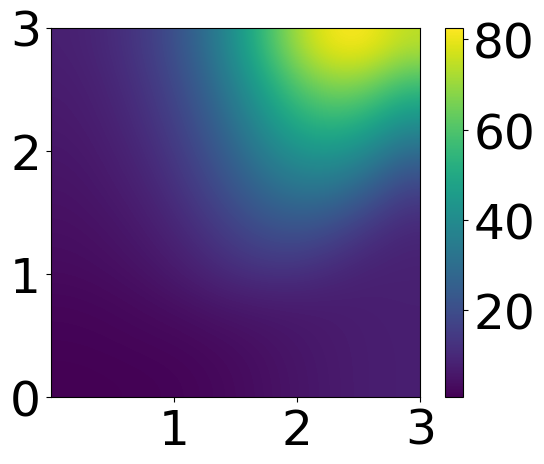

In [285]:
fig, ax = plt.subplots()

image = ax.imshow(lifetime.T, origin='lower', interpolation='bicubic', extent=[0, 3, 0, 3])

cb = plt.colorbar(image,ticks=[0, 20, 40, 60, 80]) 
cb.ax.tick_params(labelsize=35)

plt.xticks([1, 2, 3], fontsize=35)
plt.yticks([0, 1,2,3], fontsize=35)

save_file('lifetime_ncrick')
plt.show()

## n. Capacity vs $k$ and $N$ for Crick switch

Plot capacity vs $k$ and $N$ for Crick switch. We considered three orders of magnitude for $k$ and $N$: $k$ between $1$ and $1000$, and $N$ between $1$ and $1000$. 

In [295]:
def get_capacity_ncrick(eps, gamma, k, N):
    small = 1e-10
    p_crick = (eps*(eps + k)/( (eps + gamma)**2 + k*eps  ) + small)**N
    C = get_capacity(p_crick)
    return C

num_k = 3
num_N = 3

k = np.logspace(0, 3, 10); num_k = len(k)
N = np.unique(np.logspace(0, 3, 10, dtype=int)); num_N = len(N)
k_, N_ = np.meshgrid(k, N, indexing='ij')


C = get_capacity_ncrick(0.01, 1., k_, N_)

# fix numerical errors due to capacities very close to 1 registering as NAN
for i in range(0, num_k):
    for j in range(0, num_N):
        if np.isnan(C[i,j]):
            C[i,j] = 1

/Users/vastola/Documents/GitHub/crick-basic/code/functions/MI.py:50: RuntimeWarning: divide by zero encountered in log2
  #num_things = len(params_list)
/Users/vastola/Documents/GitHub/crick-basic/code/functions/MI.py:50: RuntimeWarning: invalid value encountered in multiply
  #num_things = len(params_list)


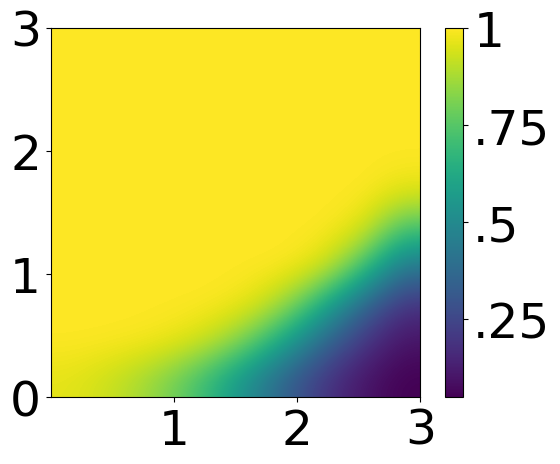

In [297]:
fig, ax = plt.subplots()

image = ax.imshow(C.T, origin='lower', interpolation='bicubic', extent=[0, 3, 0, 3])

cb = plt.colorbar(image,ax=ax,ticks=[0, .25, 0.5, 0.75, 1])
cb.ax.tick_params(labelsize=35)
cb.ax.set_yticklabels(['0','.25','.5','.75','1'])
plt.xticks([1, 2, 3], fontsize=35)
plt.yticks([0, 1,2,3], fontsize=35)
save_file('capacity_ncrick')
plt.show()

## o. Performance vs $k$ and $N$ for Crick switch

Plot performance vs $k$ and $N$ for Crick switch. We considered three orders of magnitude for $k$ and $N$: $k$ between $1$ and $1000$, and $N$ between $1$ and $1000$. Most of the necessary computation (of `MI_grid`) was done above under panel (m).

In [ ]:
# OPTIONAL: load results
# with open('results/data/ncrick_MIgrid.pickle', 'rb') as f:
#                 MI_grid = pickle.load(f)

In [289]:
perf_grid = get_performances_2D(t, k, N, MI_grid, tau=100)

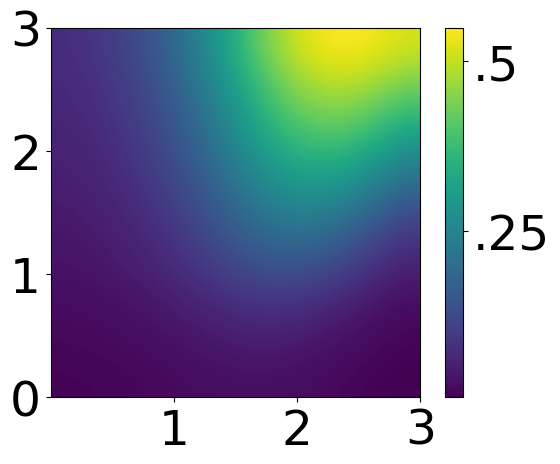

In [291]:
fig, ax = plt.subplots()

image = ax.imshow(perf_grid.T, origin='lower', interpolation='bicubic', extent=[0, 3, 0, 3])

cb = plt.colorbar(image,ticks=[0, 0.25, 0.5]) 
cb.ax.tick_params(labelsize=35)
cb.ax.set_yticklabels(['0','.25', '.5'])
plt.xticks([1, 2, 3], fontsize=35)
plt.yticks([0, 1,2,3], fontsize=35)
save_file('performances_ncrick')
plt.show()